# **Part 2 - Can we omit some controls?**

Graph the DAG that represents the following causal effects:

*   $X$ → $Y$  
*   $Z_1$ → $X$, $Z_1$ → $Y$
*   $Z_2$ → $X$, $Z_2$ → $Y$
*   $Z_3$ → $Z_2$, $Z_3$ → $Y$

Assume that every causal arrow represents a true effect of one and simulate the data (just like in the lab).  
So for example $Z_1$ → $X$ means that $Z_1$ = $ε$<sub>$Z$<sub>$1$</sub></sub> and $X$ = $Z_1$ $+$ $ε_X$

***DAG***

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
"Ignoring unknown parameters: linewidth"

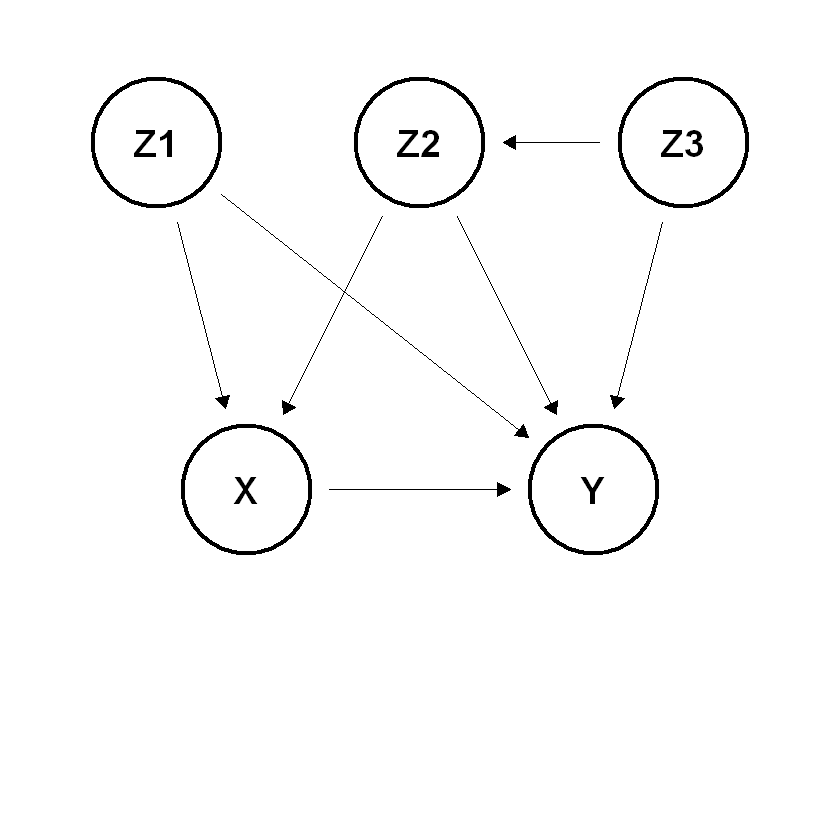

In [2]:
library(ggplot2)
library(grid)

# Set up
unit_vec <- function(p, q) {
  v <- q - p
  n <- sqrt(sum(v^2))
  if (n > 0) v / n else v
}

shrink_segment <- function(p, q, r) {
  u <- unit_vec(p, q)
  list(p1 = p + r * u, p2 = q - r * u)
}

# Nodos
Z1 <- c(0.12, 0.90)
Z2 <- c(0.50, 0.90)
Z3 <- c(0.88, 0.90)
X <- c(0.25, 0.40)
Y <- c(0.75, 0.40)
R <- 0.12

nodes <- data.frame(
  x = c(Z1[1], Z2[1], Z3[1], X[1], Y[1]),
  y = c(Z1[2], Z2[2], Z3[2], X[2], Y[2]),
  label = c("Z₁", "Z₂", "Z₃", "X", "Y")
)

# Flechas
arrows_list <- list(
  c(X[1], X[2], Y[1], Y[2]),      # X -> Y
  c(Z1[1], Z1[2], X[1], X[2]),    # Z1 -> X
  c(Z1[1], Z1[2], Y[1], Y[2]),    # Z1 -> Y
  c(Z2[1], Z2[2], X[1], X[2]),    # Z2 -> X
  c(Z2[1], Z2[2], Y[1], Y[2]),    # Z2 -> Y
  c(Z3[1], Z3[2], Z2[1], Z2[2]),  # Z3 -> Z2
  c(Z3[1], Z3[2], Y[1], Y[2])     # Z3 -> Y
)

arrows_df <- do.call(rbind, lapply(arrows_list, function(arr) {
  p <- c(arr[1], arr[2])
  q <- c(arr[3], arr[4])
  shrunk <- shrink_segment(p, q, R)
  data.frame(x = shrunk$p1[1], y = shrunk$p1[2], 
             xend = shrunk$p2[1], yend = shrunk$p2[2])
}))

# Crear el gráfico
p <- ggplot() +
  geom_segment(data = arrows_df, 
               aes(x = x, y = y, xend = xend, yend = yend),
               arrow = arrow(length = unit(0.3, "cm"), type = "closed"),
               linewidth = 1, color = "black") +
  geom_point(data = nodes, aes(x = x, y = y), 
             size = 35, shape = 21, fill = "white", 
             color = "black", stroke = 2) +
  geom_text(data = nodes, aes(x = x, y = y, label = label),
            size = 8, fontface = "bold") +
  # Configuración
  coord_fixed(ratio = 1) +
  xlim(-0.05, 1.05) +
  ylim(-0.05, 1.05) +
  theme_void() +
  theme(plot.background = element_rect(fill = "white", color = NA))

# Visualización
ggsave("dag_causal_part2_R.png", p, width = 8, height = 6, dpi = 300)
print(p)

***Simulación***

In [4]:
library(broom)

# Set up
set.seed(42)
sample <- runif(1000000) < 0.001
sample_indices <- which(sample)

# Simulación del DAG
pop_Z1 <- rnorm(1000000)
pop_Z3 <- rnorm(1000000)
pop_Z2 <- pop_Z3 + rnorm(1000000)
pop_X <- pop_Z1 + pop_Z2 + rnorm(1000000)
pop_Y <- pop_X + pop_Z1 + pop_Z2 + pop_Z3 + rnorm(1000000)

# Regresión 1: Y ~ X
cat("=== Regresión 1: Y ~ X ===\n")
model1 <- lm(pop_Y[sample_indices] ~ pop_X[sample_indices] - 1)
print(summary(model1))

# Regresión 2: Y ~ X + Z1
cat("\n=== Regresión 2: Y ~ X + Z1 ===\n")
model2 <- lm(pop_Y[sample_indices] ~ pop_X[sample_indices] + pop_Z1[sample_indices] - 1)
print(summary(model2))

# Regresión 3: Y ~ X + Z2
cat("\n=== Regresión 3: Y ~ X + Z2 ===\n")
model3 <- lm(pop_Y[sample_indices] ~ pop_X[sample_indices] + pop_Z2[sample_indices] - 1)
print(summary(model3))

# Regresión 4: Y ~ X + Z3
cat("\n=== Regresión 4: Y ~ X + Z3 ===\n")
model4 <- lm(pop_Y[sample_indices] ~ pop_X[sample_indices] + pop_Z3[sample_indices] - 1)
print(summary(model4))

# Regresión 5: Y ~ X + Z1 + Z2 + Z3
cat("\n=== Regresión 5: Y ~ X + Z1 + Z2 + Z3 ===\n")
model5 <- lm(pop_Y[sample_indices] ~ pop_X[sample_indices] + pop_Z1[sample_indices] + 
             pop_Z2[sample_indices] + pop_Z3[sample_indices] - 1)
print(summary(model5))

=== Regresión 1: Y ~ X ===

Call:
lm(formula = pop_Y[sample_indices] ~ pop_X[sample_indices] - 
    1)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.8438 -1.1300  0.1299  1.2804  5.5361 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
pop_X[sample_indices]  2.05816    0.02699   76.25   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.786 on 1017 degrees of freedom
Multiple R-squared:  0.8511,	Adjusted R-squared:  0.851 
F-statistic:  5814 on 1 and 1017 DF,  p-value: < 2.2e-16


=== Regresión 2: Y ~ X + Z1 ===

Call:
lm(formula = pop_Y[sample_indices] ~ pop_X[sample_indices] + 
    pop_Z1[sample_indices] - 1)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.8458 -1.1226  0.1293  1.2868  5.5321 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
pop_X[sample_indices]  2.056272   0.030454  67.520   <2e-16 ***
pop_Z1[sample_indices] 0.008376   0.062296   0.134

Focus your attention on the effect of $X$ on $Y$. The goal is to have a good estimation for the effect of $X$ on $Y$ with the least number of controls as possible. To do so, follow the following instructions. In one single graph, plot the point estimate with confidence intervals (significant at 1\%) of the following regressions.

*   $Y$ vs. $X$
*   $Y$ vs. $X$, $Z_1$
*   $Y$ vs. $X$, $Z_2$
*   $Y$ vs. $X$, $Z_1$, $Z_2$
*   $Y$ vs. $X$, $Z_1$, $Z_2$, $Z_3$

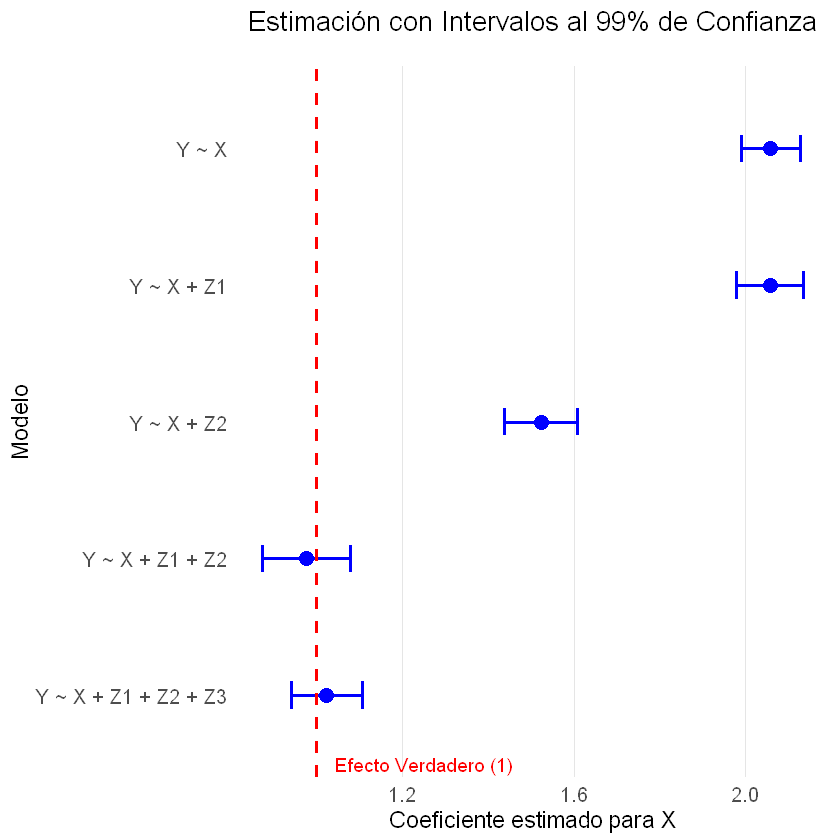

In [6]:
# Cargar librerías
library(ggplot2)

# Set up
set.seed(42)
sample <- runif(1000000) < 0.001
sample_indices <- which(sample)

# Simulación
pop_Z1 <- rnorm(1000000)
pop_Z3 <- rnorm(1000000)
pop_Z2 <- pop_Z3 + rnorm(1000000)
pop_X <- pop_Z1 + pop_Z2 + rnorm(1000000)
pop_Y <- pop_X + pop_Z1 + pop_Z2 + pop_Z3 + rnorm(1000000)

results <- list()

# 1. Y ~ X
model1 <- lm(pop_Y[sample_indices] ~ pop_X[sample_indices] - 1)
coef1 <- coef(model1)[1]
ci1 <- confint(model1, level = 0.99)[1, ]
results[[1]] <- list(model = "Y ~ X", coef = coef1, lower = ci1[1], upper = ci1[2])

# 2. Y ~ X + Z1
model2 <- lm(pop_Y[sample_indices] ~ pop_X[sample_indices] + pop_Z1[sample_indices] - 1)
coef2 <- coef(model2)[1]
ci2 <- confint(model2, level = 0.99)[1, ]
results[[2]] <- list(model = "Y ~ X + Z1", coef = coef2, lower = ci2[1], upper = ci2[2])

# 3. Y ~ X + Z2
model3 <- lm(pop_Y[sample_indices] ~ pop_X[sample_indices] + pop_Z2[sample_indices] - 1)
coef3 <- coef(model3)[1]
ci3 <- confint(model3, level = 0.99)[1, ]
results[[3]] <- list(model = "Y ~ X + Z2", coef = coef3, lower = ci3[1], upper = ci3[2])

# 4. Y ~ X + Z1 + Z2
model4 <- lm(pop_Y[sample_indices] ~ pop_X[sample_indices] + pop_Z1[sample_indices] + 
             pop_Z2[sample_indices] - 1)
coef4 <- coef(model4)[1]
ci4 <- confint(model4, level = 0.99)[1, ]
results[[4]] <- list(model = "Y ~ X + Z1 + Z2", coef = coef4, lower = ci4[1], upper = ci4[2])

# 5. Y ~ X + Z1 + Z2 + Z3
model5 <- lm(pop_Y[sample_indices] ~ pop_X[sample_indices] + pop_Z1[sample_indices] + 
             pop_Z2[sample_indices] + pop_Z3[sample_indices] - 1)
coef5 <- coef(model5)[1]
ci5 <- confint(model5, level = 0.99)[1, ]
results[[5]] <- list(model = "Y ~ X + Z1 + Z2 + Z3", coef = coef5, lower = ci5[1], upper = ci5[2])

# Preparar datos para el gráfico
df_plot <- data.frame(
  model = sapply(results, function(x) x$model),
  coef = sapply(results, function(x) x$coef),
  lower = sapply(results, function(x) x$lower),
  upper = sapply(results, function(x) x$upper)
)
df_plot$model <- factor(df_plot$model, levels = rev(df_plot$model))

# Gráfico
p <- ggplot(df_plot, aes(x = coef, y = model)) +
  geom_point(size = 4, color = "blue") +
  geom_errorbarh(aes(xmin = lower, xmax = upper), 
                 height = 0.2, size = 1, color = "blue") +
  geom_vline(xintercept = 1, linetype = "dashed", color = "red", size = 1) +
  annotate("text", x = 1, y = 0.5, label = "Efecto Verdadero (1)", 
           color = "red", hjust = -0.1, size = 4) +
  labs(x = "Coeficiente estimado para X",
       y = "Modelo",
       title = "Estimación con Intervalos al 99% de Confianza") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16, hjust = 0.5, margin = margin(b = 20)),
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12),
    panel.grid.major.y = element_blank(),
    panel.grid.minor = element_blank(),
    panel.grid.major.x = element_line(colour = "grey90")
  )

# Guardar y mostrar
ggsave("estimacion_ic_part2.png", p, width = 12, height = 8, dpi = 300)
print(p)

Based on your results, answer the following



*   Which regressions seem to estimate the effect correctly?
*   Print a summary table for regressions (4) and (5). What can you comment on the point estimate and precesion?
*   Can you ignore some $Z$ $∈$ $Z_1$, $Z_2$, $Z_3$ and get a good estimate? Why do you think that is?

In [7]:
# Regresión 4: Y ~ X + Z₁ + Z₂
cat("=== REGRESIÓN 4: Y ~ X + Z₁ + Z₂ ===\n")
print(summary(model4))

# Regresión 5: Y ~ X + Z₁ + Z₂ + Z₃  
cat("\n=== REGRESIÓN 5: Y ~ X + Z₁ + Z₂ + Z₃ ===\n")
print(summary(model5))

=== REGRESIÓN 4: Y ~ X + Z1 + Z2 ===

Call:
lm(formula = pop_Y[sample_indices] ~ pop_X[sample_indices] + 
    pop_Z1[sample_indices] + pop_Z2[sample_indices] - 1)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.7540 -0.8205  0.0500  0.8754  3.7773 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
pop_X[sample_indices]   0.97524    0.03978   24.52   <2e-16 ***
pop_Z1[sample_indices]  1.06850    0.05476   19.51   <2e-16 ***
pop_Z2[sample_indices]  1.58304    0.04909   32.25   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.256 on 1015 degrees of freedom
Multiple R-squared:  0.9265,	Adjusted R-squared:  0.9263 
F-statistic:  4263 on 3 and 1015 DF,  p-value: < 2.2e-16


=== REGRESIÓN 5: Y ~ X + Z1 + Z2 + Z3 ===

Call:
lm(formula = pop_Y[sample_indices] ~ pop_X[sample_indices] + 
    pop_Z1[sample_indices] + pop_Z2[sample_indices] + pop_Z3[sample_indices] - 
    1)

Residuals:
    Min      1Q  Me

# **Análisis de Resultados**

### ***¿Qué regresiones estiman correctamente el efecto?***

Las regresiones **(4) Y ~ X + Z1 + Z2** y **(5) Y ~ X + Z1 + Z2 + Z3** estiman correctamente el efecto causal de X sobre Y (valor real = 1):
- **Regresión 4**: Coeficiente = 0.9752 (IC 99%: [0.872, 1.078])
- **Regresión 5**: Coeficiente = 1.0233 (IC 99%: [0.941, 1.105])

Las demás regresiones sobreestiman el efecto porque no controlan por los confounders necesarios (Z1 y Z2).

### ***Comparación de regresiones 4 y 5***

| Aspecto | Regresión 4 | Regresión 5 |
|---------|---------------|---------------|
| **Coef. de X** | 0.9752 | 1.0233 |
| **Error estándar** | 0.0398 | 0.0317 |
| **R² ajustado** | 0.9263 | 0.9535 |
| **Coef. de Z2** | 1.5830 | 0.9915 |

**Observación**

La regresión (5) es más precisa (menor error estándar: 0.0317 vs 0.0398) y todos sus coeficientes están cercanos a 1.0, reflejando correctamente la estructura causal del DAG. En la regresión (4), el coeficiente de Z2 está inflado (1.58 vs 0.99) porque captura parte del efecto omitido de Z3.

### ***¿Se puede ignorar alguna Z y obtener una buena estimación?***

Para estimar solo el efecto de X sobre Y sí, se puede ignorar Z3. La regresión (4) da una estimación prácticamente correcta (0.9752 ≈ 1.0).
Sin embargo, omitir Z3 causa sesgo de variable omitida en los coeficientes de control, especialmente en Z2, que absorbe parte del efecto de Z3.

**Conclusión**

Si solo interesa el efecto de X sobre Y con el mínimo de variables, se puede usar la regresión (4) con Z1 y Z2. Pero si se quiere entender correctamente toda la estructura causal sin sesgos, la regresión (5) con todos los controles es superior por su mayor precisión y coeficientes correctos.